<a href="https://colab.research.google.com/github/hamzafarooq/pycaret/blob/master/TimeSeries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Set Overivew

The tutorial uses the [Iowa Liquor Retails Sales](https://console.cloud.google.com/marketplace/details/iowa-department-of-commerce/iowa-liquor-sales). We will be using the dataset to predict future sales for one of the stores

This dataset contains every wholesale purchase of liquor in the State of Iowa by retailers for sale to individuals since January 1, 2012. 

The State of Iowa controls the wholesale distribution of liquor intended for retail sale, which means this dataset offers a complete view of retail liquor sales in the entire state. The dataset contains every wholesale order of liquor by all grocery stores, liquor stores, convenience stores, etc., with details about the store and location, the exact liquor brand and size, and the number of bottles ordered.

In [1]:
#importing necessary packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import numpy as np 
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Reading Data


# Using GCP and Biq Query
To setup a project on Google Cloud Platform and use Big Query go to: http://console.cloud.google.com

You can also watch my tutorial here: https://www.youtube.com/watch?v=m5qQ5GLmcZs

In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')



Authenticated


# Pulling data for one store. 
This dataset has quite a few dimensions, however, we will focus on just part for now which is just one store and for sales that have occured after 1st Jan 2018

In [4]:
%%bigquery --project bold-sorter-281506 df2  # bold-sorter-281506 df2 is the project id ; df2 is the dataframe name
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
where store_number  = '2633'
and date > '2018-01-01'

# Using a direct link
A version of this dataset is also saved on my google drive. We can use it to pull the dataset


In [2]:
import pandas as pd

url = 'https://drive.google.com/file/d/1g3UG_SWLEqn4rMuYCpTHqPlF0vnIDRDB/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df2 = pd.read_csv(path)

In [3]:
path #save this path, just in case

'https://drive.google.com/uc?export=download&id=1g3UG_SWLEqn4rMuYCpTHqPlF0vnIDRDB'

# Data Overview

In [4]:
df2.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-19309700006,2019-05-13,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300.0,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,84,4409.16,63.0,16.64
1,INV-15347200002,2018-10-29,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1011600.0,Straight Rye Whiskies,214,GoAmericaGo Beverages LLC,27145,WhistlePig Old World 12YR,6,750,64.17,96.26,30,2887.80,22.5,5.94
2,INV-11117400006,2018-03-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1901200.0,Special Order Items,459,SURVILLE ENTERPRISES CORP,904955,1921 Tequila Reposado,6,750,26.50,39.75,12,477.00,9.0,2.38
3,INV-10206700012,2018-02-05,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1012300.0,Single Malt Scotch,266,Edrington Group USA LLC,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,12,566.88,9.0,2.38
4,INV-11743500040,2018-04-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1011600.0,Straight Rye Whiskies,306,MISSISSIPPI RIVER DISTIL,27027,Cody Road Rye,6,750,19.17,28.76,6,172.56,4.5,1.19


In [5]:
df2_ds = df2[['date','sale_dollars']] # selecting the needed columns


In [6]:
df2_ds=df2_ds.sort_index(axis=0)

In [7]:
df2_ds.tail(5)

,date,sale_dollars
50522,2019-12-09,1379.88
50523,2019-11-25,148.50
50524,2019-10-24,119.28
50525,2019-10-17,119.28
50526,2019-10-21,279.00


In [8]:
aggregated=df2_ds.groupby('date',as_index=True).sum()

In [9]:
print(min(aggregated.index))
print(max(aggregated.index))

2018-01-03
2020-07-30


In [10]:
aggregated.index=pd.to_datetime(aggregated.index)

#Create Fetaures
There are multiple ways of creating features, however, we will explore simpler ones - There are a few others, which I have commented for now

In [11]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['flag'] = pd.Series(np.where(df['date'] >= np.datetime64('2020-03-03'), 1, 0), index=df.index) #flag for COVID-19
    #df['rolling_mean_7'] = df['sale_dollars'].shift(7).rolling(window=7).mean()
    #df['lag_7'] = df['sale_dollars'].shift(7)
    #df['lag_15']=df['sale_dollars'].shift(15)
    #df['lag_last_year']=df['sale_dollars'].shift(52).rolling(window=15).mean()
  
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','flag','sale_dollars']]
    X.index=df.index
    return X

In [12]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

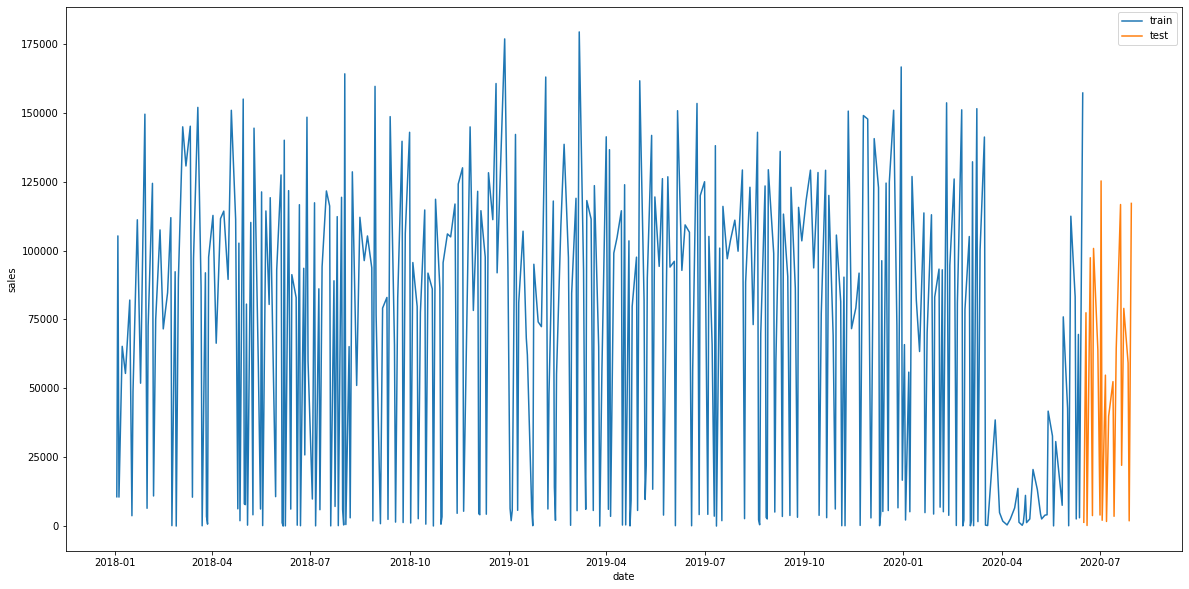

In [13]:
aggregated=create_features(aggregated)
train, test = split_data(aggregated, '2020-06-15') # splitting the data for training before 15th June

plt.figure(figsize=(20,10))
plt.xlabel('date')
plt.ylabel('sales')
plt.plot(train.index,train['sale_dollars'],label='train')
plt.plot(test.index,test['sale_dollars'],label='test')
plt.legend()
plt.show()


There is a lot of variation within the date, also, the dates are not continous, that is, there are gaps - we can do two things here, impute missing date or let it be. A major reason we will not create missing dates is because we are considering this data for predictive modeling rather than time series forecasting - hence the data is not depenent on the immediate past but the relationship of the features with sales over time

In [14]:
train.tail(4)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars
date,,,,,,,,,
2020-06-09,1,2,6,2020,161,9,24,1,2588.94
2020-06-11,3,2,6,2020,163,11,24,1,69550.07
2020-06-12,4,2,6,2020,164,12,24,1,3011.43
2020-06-15,0,2,6,2020,167,15,25,1,157158.24


# Run PyCaret

In [15]:
#!pip install pycaret 

In [16]:
from pycaret.regression import *

Setting up the model is extremely easy

In [17]:
reg = setup(data = train, 
             target = 'sale_dollars',
             numeric_imputation = 'mean',
             categorical_features = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear',
                                     'flag']  , 
            transformation = True, transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.1,
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, 
             silent = True)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,7424
1,Transform Target,True
2,Transform Target Method,yeo-johnson
3,Original Data,"(385, 9)"
4,Missing Values,False
5,Numeric Features,0
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


As a data scientist, I can't emphasize more on the usefulness of the function below - instead of pulling every single model, we just need one line to compare 20 different models! **This is insane!**

In [20]:
# returns best models - takes a little time to run
top3 = compare_models(n_select = 3)

# Creating baseline model

In [21]:
#we create a model using light gbm
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,27679.6948,2264608200.9779,47587.8997,0.1911,1.5253,2.2537
1,20146.7760,1059222094.4910,32545.6924,0.4035,1.8166,7.3706
2,22913.6495,1294520352.8960,35979.4435,0.6390,1.4485,4.7131
3,26302.5325,1491153629.4319,38615.4584,0.4787,1.3046,2.7212
4,12672.3047,290505824.6281,17044.2314,0.9023,0.4905,0.2488
5,22265.6809,1132222959.3479,33648.5209,0.5073,1.3927,4.4580
6,30089.5524,1691057520.9404,41122.4698,0.2322,1.2405,1.7433
7,12221.3108,292726304.6515,17109.2462,0.8936,2.2399,22.8773
8,14928.2425,446448142.5014,21129.3195,0.8614,2.1695,43.4240
9,23426.3357,1138782924.7624,33745.8579,0.7069,1.4152,5.9508


Being able to tune seamlessly and hardly writing a line is extremely useful

In [23]:
tuned_lightgbm = tune_model(lightgbm) 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,27525.6125,2188265059.7911,46778.8955,0.2184,1.5539,3.3718
1,18019.6723,863400098.0486,29383.6706,0.5138,1.8434,9.8548
2,20623.1988,999423968.3243,31613.6674,0.7213,1.3855,5.2175
3,25424.1035,1381560599.9128,37169.3503,0.5170,1.2760,4.4262
4,18984.4180,714664998.4672,26733.2190,0.7597,0.4317,0.3100
5,23495.2458,1221173459.3436,34945.2924,0.4686,1.3011,4.6471
6,28569.3458,1518469599.4612,38967.5455,0.3106,1.0935,1.9208
7,14249.2330,440531493.3635,20988.8421,0.8398,2.2965,24.1798
8,14287.6710,393175643.5341,19828.6571,0.8779,2.1633,39.8652
9,23791.5429,1120916367.6505,33480.0891,0.7115,1.3428,4.9723


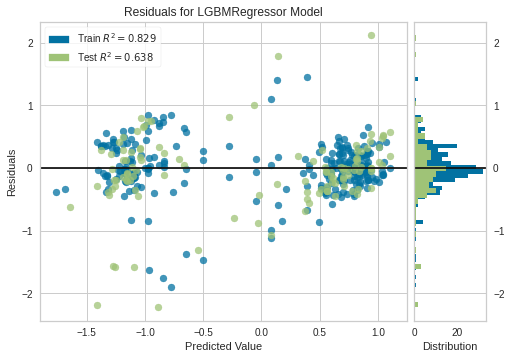

In [24]:
plot_model(lightgbm)

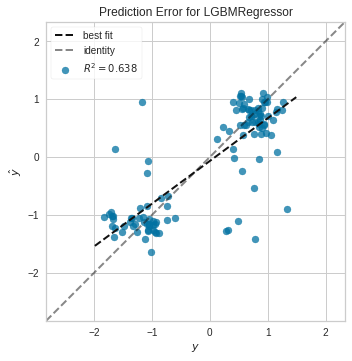

In [25]:
plot_model(lightgbm, plot = 'error')

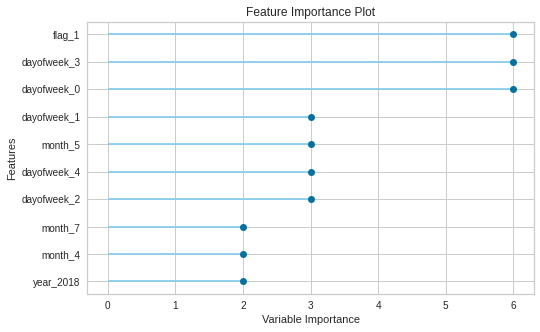

In [40]:
plot_model(tuned_lightgbm, plot='feature') # looks like COVID-19 has played a huge role in sales

In [27]:
predict_model(tuned_lightgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,22274.3454,1.252090e+09,35384.8774,0.5623,1.4822,0 8.186057 dtype: float64


In [28]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [29]:
#Final Light Gradient Boosting Machine parameters for deployment
print(final_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=40,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.2,
              n_estimators=150, n_jobs=-1, num_leaves=100, objective=None,
              random_state=7424, reg_alpha=0.2, reg_lambda=0.2, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [30]:
predict_model(final_lightgbm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,21132.048,1.118844e+09,33449.1286,0.6089,1.4375,0 7.273443 dtype: float64


In [45]:
unseen_predictions = predict_model(final_lightgbm, data=test)
unseen_predictions.head()
unseen_predictions.loc[unseen_predictions['Label'] < 0, 'Label'] = 0 #removing any negative values

In [46]:
def plot_series(time, series,i, format="-", start=0, end=None):
    #plt.figure(figsize=(20,10))
    plt.plot(time[start:end], series[start:end], format,label=i)
    plt.xlabel("Date")
    plt.ylabel("Sales (Dollar)")
    plt.legend()

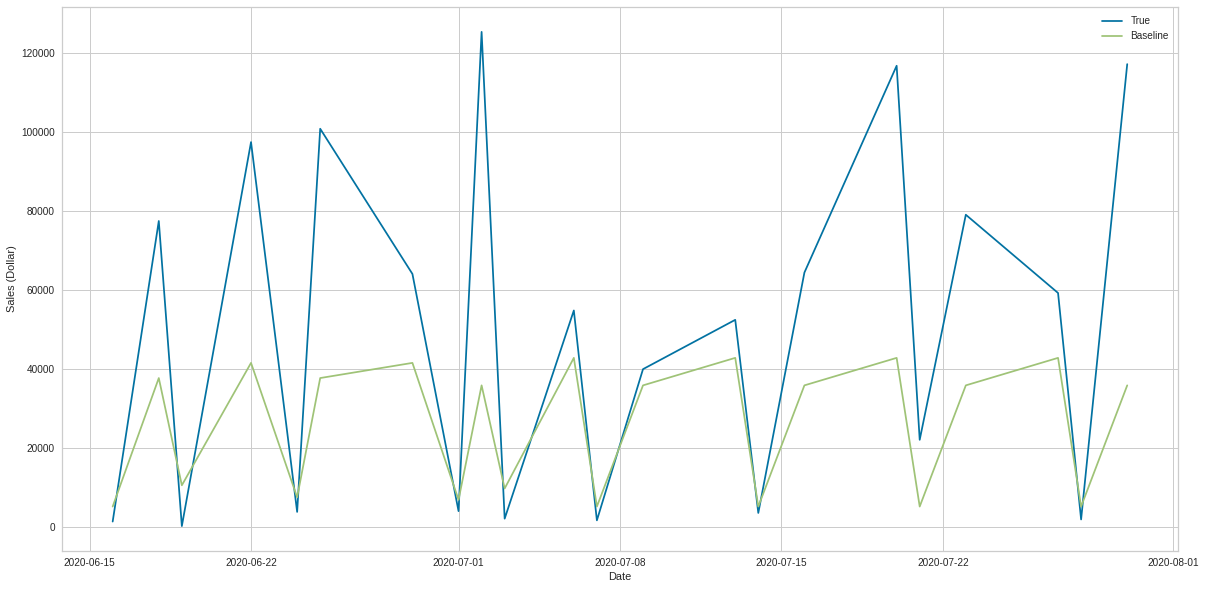

In [53]:
plt.figure(figsize=(20,10))
plot_series(test.index, test['sale_dollars'],"True")
#plot_series(train['ds'],train['y'])
plot_series(test.index, unseen_predictions['Label'],"Baseline")

Introducing a new metric, SMAPE - this works really well when there are a lot of 0's in the data - like this one. Please note, 0 is not a missing value

In [48]:
def calc_smape(y_hat, y):
        return 100/len(y) * np.sum(2 * np.abs(y_hat - y) / (np.abs(y) + np.abs(y_hat)))


In [49]:
calc_smape(test['sale_dollars'].values,unseen_predictions['Label'].values)

78.31078994510081

We will consider 78.3 as our baseline SMAPE 

# Blending Models
We will now create a blend model using four algorithms, huber, random forest, xgboost and lightgbm

In [38]:
#huber = create_model('huber', verbose = False)
rf = create_model('rf', verbose = False)
lightgbm = create_model('lightgbm', verbose = False)
xgb = create_model('xgboost',verbose=False)


In [60]:
tuned_rf = tune_model(rf)
tuned_huber = tune_model(huber)
tuned_lightgbm = tune_model(lightgbm)
tuned_xgb = tune_model(xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,26204.8845,2194178302.1632,46842.0570,0.2163,1.6064,2.1330
1,24156.1229,1460002937.0579,38209.9848,0.1778,1.9453,11.8847
2,26934.1278,1459559865.2131,38204.1865,0.5929,1.7032,3.4440
3,28300.8083,1661870492.5534,40766.0458,0.4190,1.3617,2.0544
4,14078.1126,373011178.3488,19313.4973,0.8746,0.9034,0.3158
5,23892.8310,1239245903.1661,35202.9246,0.4608,1.4607,4.3862
6,29783.0525,1726573549.1814,41552.0583,0.2161,1.2092,2.3582
7,10645.6674,240928405.1008,15521.8686,0.9124,2.1513,8.1955
8,14011.3135,355327621.4132,18850.1358,0.8897,2.0924,35.1778
9,21220.0470,952218812.1188,30858.0429,0.7549,1.3684,4.9820


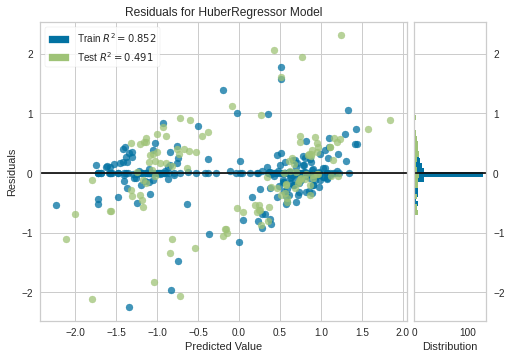

In [62]:
plot_model(tuned_huber)

The below script will just blend all the four models in to one - the time savings are phenomenal

In [61]:
blend_specific = blend_models(estimator_list = [tuned_rf,tuned_lightgbm,tuned_xgb,tuned_huber])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,26273.0689,2123700307.0776,46083.6230,0.2414,1.5490,1.9877
1,19837.2453,1133550913.4282,33668.2479,0.3616,1.8145,8.1207
2,23571.7193,1107879591.3639,33284.8252,0.6910,1.3199,4.6199
3,24291.6852,1290276880.1814,35920.4243,0.5489,1.2278,3.9043
4,15501.2957,507780986.5664,22533.9962,0.8292,0.5135,0.3012
5,20724.9844,1196060866.1864,34584.1129,0.4795,1.2372,2.2119
6,30832.8317,1721788508.9333,41494.4395,0.2183,1.1698,2.0790
7,10463.0900,221820014.4671,14893.6233,0.9194,2.1726,11.6417
8,14531.6365,395795499.5931,19894.6098,0.8771,2.0696,27.9784
9,23860.4352,1212252856.1683,34817.4217,0.6880,1.2720,3.8714


In [63]:
predict_model(blend_specific);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,22782.1274,1.257876e+09,35466.5436,0.5603,1.5146,0 7.618574 dtype: float64


In [64]:
final_model = finalize_model(blend_specific)

In [65]:
unseen_predictions_2 = predict_model(final_model, data=test, round=0)
unseen_predictions_2.loc[unseen_predictions_2['Label'] < 0, 'Label'] = 0
unseen_predictions_2.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars,Label
0,1,2,6,2020,168,16,25,1,1376.22,5256.0
1,3,2,6,2020,170,18,25,1,77424.58,53005.0
2,4,2,6,2020,171,19,25,1,226.68,5157.0
3,0,2,6,2020,174,22,26,1,97385.87,58606.0
4,2,2,6,2020,176,24,26,1,3810.90,7859.0


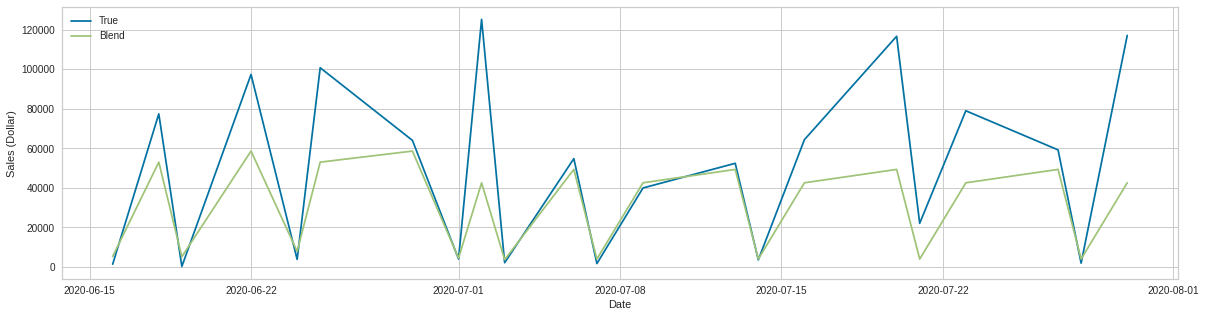

In [66]:
plt.figure(figsize=(20,5))
plot_series(test.index, test['sale_dollars'],"True")
plot_series(test.index, unseen_predictions_2['Label'],'Blend')


In [67]:
calc_smape(test['sale_dollars'].values,unseen_predictions_2['Label'].values)

59.45794210582072

The blend model is a major improvment over the baseline model.

# Stacking
Let's try one more technique, stacking and see if it improves our results

In [69]:
stack_1 = stack_models([tuned_rf,tuned_xgb, tuned_lightgbm])
predict_model(stack_1);
final_stack_1 = finalize_model(stack_1)
unseen_predictions_3 = predict_model(final_stack_1, data=test, round=0)



In [73]:
unseen_predictions_3.loc[unseen_predictions_3['Label'] < 0, 'Label'] = 0
unseen_predictions_3.head(4)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars,Label
0,1,2,6,2020,168,16,25,1,1376.22,0.0
1,3,2,6,2020,170,18,25,1,77424.58,0.0
2,4,2,6,2020,171,19,25,1,226.68,0.0
3,0,2,6,2020,174,22,26,1,97385.87,0.0


In [74]:
calc_smape(test['sale_dollars'].values,unseen_predictions_3['Label'].values)

130.67629844844575

Stacking definitely did not improve the model

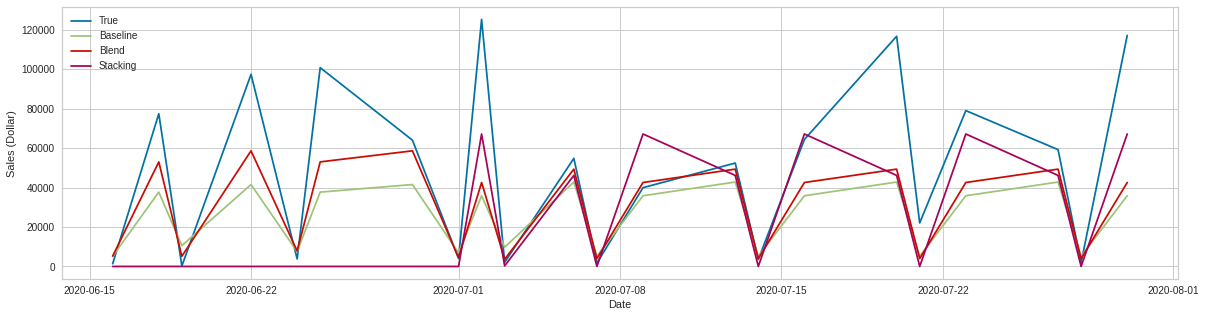

In [75]:
plt.figure(figsize=(20,5))
plot_series(test.index, test['sale_dollars'],"True")
plot_series(test.index, unseen_predictions['Label'],'Baseline')
plot_series(test.index, unseen_predictions_2['Label'],'Blend')
plot_series(test.index, unseen_predictions_3['Label'],'Stacking')

#Next Steps
The model isn't complete as yet - we can always go back to create a combination of new models + features 